In [1]:
import os
import shutil
import subprocess
from tempfile import TemporaryDirectory
from collections import defaultdict
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append('../src')
from tree import Dendrogram

In [3]:
def build_mash_sketch(assemblies, threads, temp_dir, sketch_size):
    mash_command = ['mash', 'sketch', '-p', str(threads), '-o', temp_dir + '/mash',
                    '-s', str(sketch_size)] + assemblies
    subprocess.run(mash_command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    return temp_dir + '/mash.msh'


def pairwise_mash_distances(mash_sketch, threads):
    mash_command = ['mash', 'dist', '-p', str(threads), mash_sketch, mash_sketch]
    mash_out = subprocess.run(mash_command, stdout=subprocess.PIPE).stdout.decode()
    return mash_out.splitlines()


def find_all_assemblies(in_dir):
#     print('\nLooking for assembly files in {}:'.format(in_dir))
    all_assemblies = [str(x) for x in sorted(Path(in_dir).glob('**/*'))
                      if x.is_file()]
    all_assemblies = [x for x in all_assemblies if
                      x.endswith('.fasta') or x.endswith('.fasta.gz') or
                      x.endswith('.fna') or x.endswith('.fna.gz') or
                      x.endswith('.fa') or x.endswith('.fa.gz')]
#     print('found {:,} files\n'.format(len(all_assemblies)))
    return all_assemblies

In [4]:
dirpaths = (
    '/media/Central_Lab_Storage/NcbiASM/Enterococcus_faecalis/_RefSeq', 
)

all_assemblies = []
for dirpath in dirpaths:
#     all_assemblies += find_all_assemblies(dirpath)
    all_assemblies += list(Path(dirpath).glob('*.fa'))

In [5]:
sketch_size = 10e4
threads = 64

In [6]:
with TemporaryDirectory() as temp_dir:
    mash_sketch = build_mash_sketch(all_assemblies, threads, temp_dir, sketch_size)
    pairwise_distances = pairwise_mash_distances(mash_sketch, threads)

In [74]:
from collections import defaultdict
import fastcluster
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, to_tree, dendrogram
from Bio import SeqIO

In [75]:
def N50(filename):
    contig_lengths = sorted(len(record) for record in SeqIO.parse(filename, 'fasta'))
    total_length = sum(contig_lengths)
    target_length = total_length * 0.5
    length_so_far = 0
    for contig_length in contig_lengths:
        length_so_far += contig_length
        if length_so_far >= target_length:
            return contig_length
    return length_so_far

In [323]:
distmatrix = pd.DataFrame((line.split()[:3] for line in pairwise_distances), dtype=float).pivot(0, 1, 2)

In [324]:
labels = fcluster(fastcluster.single(squareform(distmatrix)), criterion='distance', t=0.005)
len(set(labels))

117

In [325]:
clusters = defaultdict(list)
for member, label in zip(distmatrix.columns, labels):
    clusters[label].append(member)

In [326]:
clusters = list(clusters.values())

In [327]:
%%time
representative_assemblies = [max(cluster, key=N50) for cluster in clusters]

CPU times: user 5.18 s, sys: 437 ms, total: 5.62 s
Wall time: 5.66 s


In [328]:
for assembly in representative_assemblies:
    shutil.copy(assembly, '/media/Central_Lab_Storage/bo-han/Database/Escherichia_and_Shigella/Dereplication')

In [7]:
df = pd.DataFrame([line.split()[:3] for line in pairwise_distances], dtype=float).pivot(0, 1, 2)

In [8]:
df.index = map(lambda x: Path(x).stem, df.index)
df.columns = map(lambda x: Path(x).stem, df.columns)

In [9]:
dendrogram = Dendrogram(df)
dendrogram(no_labels=False)

ax = dendrogram.figure.ax
# ax.text(-.2, 0.5, 'Nanopore\nMash', transform=ax.transAxes, fontsize=22, horizontalalignment='center')

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
) 

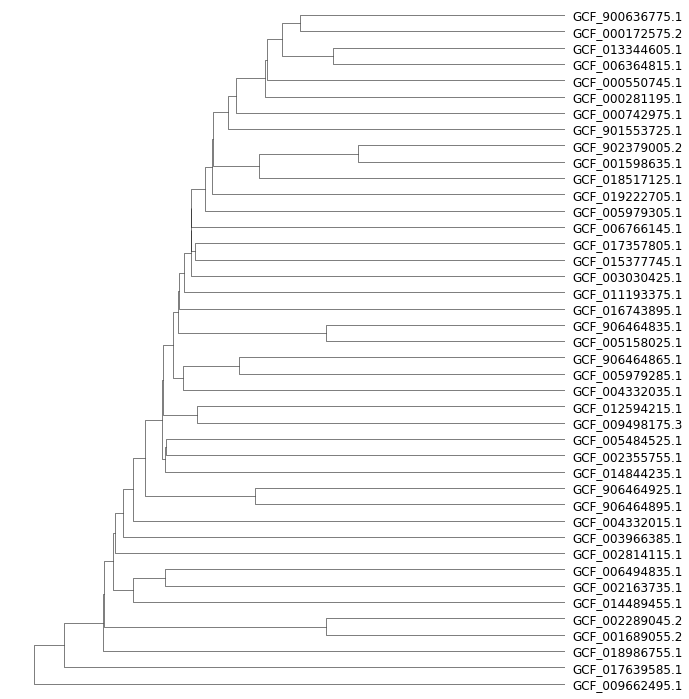

In [10]:
dendrogram.show_figure()

In [19]:
dendrogram.savefig('/media/GenomicResearch/Issue/20211223_plasmid_HI2/tree.pdf')

In [ ]:
# metadata = pd.read_csv('/media/Central_Lab_Storage/MinION/20200925/MLST/unicycler.tsv', sep='\t', usecols=[0, 1], index_col=0)
# _metadata = metadata.reindex(dendrogram.labels[::-1]).fillna('').reset_index()
# table = dendrogram.figure.ax.table(
#     cellLoc='left', colLoc='left',
#     cellText=_metadata.values,
#     colLabels=_metadata.columns,
#     bbox=[1.01, 0, 0.3, 1+1/len(dendrogram.labels)]
# )
# for key, cell in table._cells.items():
#     cell.set_linewidth(0)
#     cell.PAD = 0

# table.auto_set_font_size(False)
# table.set_fontsize(12)
# table.auto_set_column_width(range(len(_metadata.columns)))

In [ ]:
dendrogram.show_figure()

In [ ]:
dendrogram.savefig('/media/GenomicResearch/Issue/20201221_hybrid_and_denovo/Native/nanopore_with_mash.png')

In [ ]:
dendrogram.to_newick('/media/GenomicResearch/Issue/20210803_genomic_distance_with_nanopore/mash.newick')